In [ ]:
import requests 
import json
import time 
!pip install geopandas
import geopandas as gpd # for visualization

Define Export tool API URL

In [45]:
# defining the api-endpoint 
BASE_API_URL = REPLACE_WITH_EXPORT_TOOL_API_URL
# BASE_API_URL = "http://localhost:8000/latest"
  

Export tool api has two endpoints (Read API doc BASE_API_URL/redoc): /snapshot/ is main endpoint designed for huge extraction , /snapshot/plain/ api is designed to return plain geojson quickly only for few features . Here we are using /snapshot/plain/ to extract my ward boundary from /snapshot/plain/ and using the same to download buildings inside it from /snapshot/

                                            geometry   osm_id  \
0  POLYGON ((83.97318 28.20739, 83.97319 28.20732...  6272781   

                              name  
0  Pokhara Metropolitan Ward No. 8  


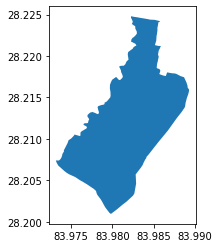

In [52]:
# Getting my ward's administrative boundary 
# https://www.openstreetmap.org/relation/6104486
payload={
  "select": [
    "name" # selecting attributes
  ],
  "where": [
    {
      "key": "boundary",
      "value": [
        "administrative" # extracting administrative boundary
      ]
    },
    {
     "key": "admin_level",
     "value": ["9"] # which has admin_level = 9 , get knowleadge about yours https://wiki.openstreetmap.org/wiki/Tag:boundary%3Dadministrative#admin_level=*_Country_specific_values
    },
    {
     "key": "name",
     "value": ["Pokhara Metropolitan Ward No. 8"]  # filtering by name of it
    }
  ],
  "joinBy": "AND", # join all by where condition by AND 
  "lookIn": [
    "relations" # since i am looking for administrative i want to look into relations 
  ],
  "geometryType": "polygon" # i want output as polygon 
}

headers = {'accept': "application/json","Content-Type": "application/json"} 
# making call to the api to get boundary
response = requests.post(url = f"{BASE_API_URL}/snapshot/plain/", data = json.dumps(payload),headers=headers)
# raise if any error occurs 
response.raise_for_status()

# extracting response , response will be in featurecollection
my_city_boundary=response.json()
df = gpd.GeoDataFrame.from_features(my_city_boundary['features'])
print(df)
df.plot()

Now we got boundary we are using it to download buildings inside it . /snapshot/ has queue system hence my request will be on queue , I will get the taskid and link where i can track status of my request . API will do it's processing and updates the task 

In [53]:
my_geom = my_city_boundary["features"][0]["geometry"] # getting geometry of my city 
pay_load_all_osm_data = {
    "geometry" : my_geom, 
    "filters": {
    "tags": {
      "all_geometry": {
        "building": [] # i want to download all buildings
      }
    }
  },
  "geometryType": [
    "point",
    "polygon"
  ]
}
task_response = requests.post(url = f"{BASE_API_URL}/snapshot/", data = json.dumps(pay_load_all_osm_data),headers=headers)
# raise if any error occurs 
task_response.raise_for_status()
result = task_response.json() # I will be on queue and it gives my unique task_id and link to track it 
print(result)

{'task_id': '4fa234a6-d2b6-48ff-9a78-6824f18696fa', 'track_link': '/tasks/status/4fa234a6-d2b6-48ff-9a78-6824f18696fa/'}


Now we got task_id and it's track link , Checking the task if it is complete or not every one second 

In [54]:
task_track_url = result['track_link']
stop_loop = False
while not stop_loop:
  check_result = requests.get(url=f"{BASE_API_URL}{task_track_url}") 
  check_result.raise_for_status()
  res=check_result.json() # status will tell current status of your task after it turns to success it will give result
  if res['status'] == 'SUCCESS'or res['status'] == 'FAILED':
    stop_loop= True
  time.sleep(1) # check each second

  print(res)
  

{'id': '4fa234a6-d2b6-48ff-9a78-6824f18696fa', 'status': 'SUCCESS', 'result': {'download_url': 'https://s3.us-east-1.amazonaws.com/exports-stage.hotosm.org/Export_geojson_uid_4fa234a6-d2b6-48ff-9a78-6824f18696fa.zip', 'file_name': 'Export', 'process_time': '0:00:00.401813', 'query_area': '1.78 Sq Km', 'binded_file_size': '1.37 MB', 'zip_file_size_bytes': 202869}}


Export tool API gives your file zipped download link , Now you can extract and use it accordingly . You can visualize / do postprocessing using python too here is one simple example to visualize using geopandas

['Export.geojson', 'clipping_boundary.geojson']
                    geometry      osm_id  version  \
0  POINT (83.98476 28.21112)  5578045433        2   
1  POINT (83.97759 28.20435)  5458133510        1   

                                                tags changeset  \
0  {'name': 'Giri Complex', 'building': 'yes', 'b...      None   
1  {'name': 'V and S. C Complex', 'building': 'yes'}      None   

             timestamp  
0  2018-06-15T11:25:56  
1  2018-03-06T04:18:24  


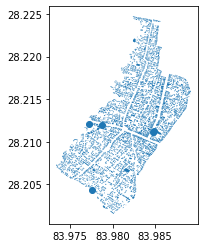

In [56]:
import io
import urllib.request
import zipfile

# Download the zip file from the URL

url = res['result']['download_url']
response = urllib.request.urlopen(url)

# Open the zip file from the response data
with zipfile.ZipFile(io.BytesIO(response.read()), 'r') as zip_ref:
    # Print the contents of the zip file
    print(zip_ref.namelist())
    with zip_ref.open('Export.geojson') as file:
        my_export_geojson=json.loads(file.read())

df = gpd.GeoDataFrame.from_features(my_export_geojson['features'])
print(df.head(2))
df.plot()